<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод:" data-toc-modified-id="Общий-вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод:</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Признаки:

RowNumber — индекс строки в данных (int64)

CustomerId — уникальный идентификатор клиента (int64)

Surname — фамилия (object)

CreditScore — кредитный рейтинг (int64)

Geography — страна проживания (object)

Gender — пол (object)

Age — возраст (int64)

Tenure — количество недвижимости у клиента (float64)

Balance — баланс на счёте (float64)

NumOfProducts — количество продуктов банка, используемых клиентом (int64)

HasCrCard — наличие кредитной карты (int64)

IsActiveMember — активность клиента (int64)

EstimatedSalary — предполагаемая зарплата (float64)

Целевой признак:

Exited — факт ухода клиента (int64)

Вывод:

В данных присутствуют столбцы (RowNumber,EstimatedSalary,CustomerId,Surname), которые не нужны для анализа - удаляем. Также есть пропуски в значении недвижимости. Это означает, что у клиента нет ее. Значит можно просто заменить 0 и перевести в целочисленный тип.

In [4]:
del_col=['RowNumber','EstimatedSalary','CustomerId','Surname']
df=df.drop(del_col,axis=1)

In [5]:
df['Tenure']=df['Tenure'].fillna(0).astype('int64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     10000 non-null  int64  
 1   Geography       10000 non-null  object 
 2   Gender          10000 non-null  object 
 3   Age             10000 non-null  int64  
 4   Tenure          10000 non-null  int64  
 5   Balance         10000 non-null  float64
 6   NumOfProducts   10000 non-null  int64  
 7   HasCrCard       10000 non-null  int64  
 8   IsActiveMember  10000 non-null  int64  
 9   Exited          10000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 781.4+ KB


In [7]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,619,France,Female,42,2,0.00,1,1,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,0
2,502,France,Female,42,8,159660.80,3,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,0


## Исследование задачи

гистограмма значений оттока и оставшихся клиентов

Text(0, 0.5, 'Количество клиентов')

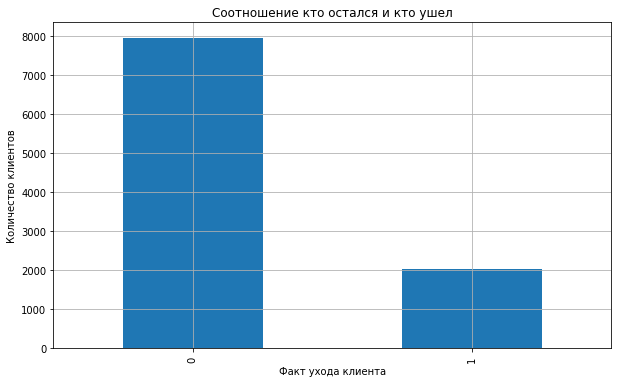

In [8]:
df['Exited'].value_counts().plot(kind='bar',grid=True,figsize=(10,6))
plt.title('Соотношение кто остался и кто ушел')
plt.xlabel('Факт ухода клиента')
plt.ylabel('Количество клиентов')

Вывод:
Соотношение оттока и тех кто остался 1:4. Такое соотношение говорит, что присутствует дисбаланс в данных.

Посмотрим как зависит возраст и отток клиентов

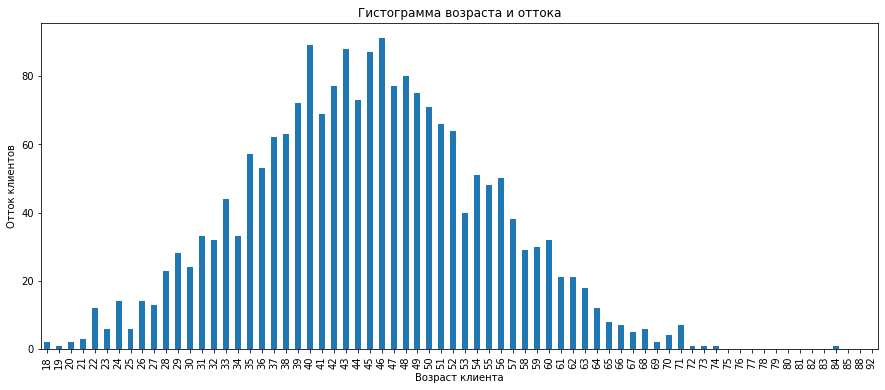

In [9]:
df.groupby('Age')['Exited'].sum().plot(figsize=(15,6),kind='bar')
plt.title('Гистограмма возраста и оттока')
plt.xlabel('Возраст клиента')
plt.ylabel('Отток клиентов')
plt.show()

Вывод:
Больше всего уходит клиентов в возрасте от 37 до 52 лет.

Посмотрим как зависит наличие недвижимости и отток клиентов

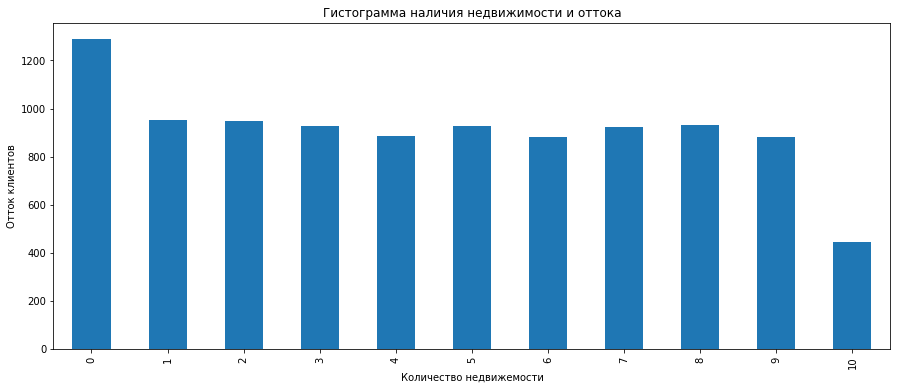

In [10]:
df.groupby('Tenure')['Exited'].count().plot(figsize=(15,6),kind='bar')
plt.title('Гистограмма наличия недвижимости и оттока')
plt.xlabel('Количество недвижемости')
plt.ylabel('Отток клиентов')
plt.show()

Вывод:
У кого нет недвижимости уходят чаще.

Text(0, 0.5, 'Баланс на счете')

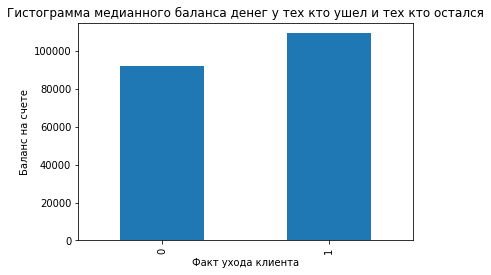

In [11]:
df.groupby('Exited')['Balance'].median().plot(kind='bar')
plt.title('Гистограмма медианного баланса денег у тех кто ушел и тех кто остался')
plt.xlabel('Факт ухода клиента')
plt.ylabel('Баланс на счете')

In [12]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
CreditScore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.005458,0.025651,-0.027094
Age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.011721,0.085472,0.285323
Tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.021387,-0.025856,-0.013319
Balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,-0.014858,-0.010084,0.118533
NumOfProducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.003183,0.009612,-0.047820
HasCrCard,-0.005458,-0.011721,0.021387,-0.014858,0.003183,1.000000,-0.011866,-0.007138
IsActiveMember,0.025651,0.085472,-0.025856,-0.010084,0.009612,-0.011866,1.000000,-0.156128
Exited,-0.027094,0.285323,-0.013319,0.118533,-0.047820,-0.007138,-0.156128,1.000000


Вывод:
Видно, что все признаки не сильно коррелируются с целевым признаком.

In [14]:
target = df['Exited']
target_test = df['Exited']
features = df.drop('Exited', axis=1)
features_test = df.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features, target, test_size=0.5, random_state=12345) 

features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric]  = scaler.transform(features_valid[numeric])
features_test[numeric]  = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

print(features_train.head())

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
7479    -0.886751 -0.373192  1.104696  1.232271              1          1   
3411     0.608663 -0.183385  1.104696  0.600563              1          0   
6027     2.052152  0.480939 -0.503694  1.027098              2          0   
1247    -1.457915 -1.417129  0.461340 -1.233163              2          1   
3716     0.130961 -1.132419 -0.825373  1.140475              1          0   

      IsActiveMember  Geography_Germany  Geography_Spain  Gender_Male  
7479               0                  0                1            1  
3411               0                  0                0            0  
6027               1                  1                0            1  
1247               0                  0                0            1  
3716               0                  1                0            0  


In [15]:
features_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Geography_Germany,Geography_Spain,Gender_Male
7867,-0.128659,0.670745,-0.503694,-1.233163,1,1,1,0,1,0
1402,1.086364,-0.942612,1.104696,0.864700,1,1,0,0,0,1
8606,1.605605,0.291132,0.139662,-1.233163,2,1,1,0,1,1
8885,0.162116,0.575842,-0.182016,0.416809,2,1,1,0,1,1
6494,0.484045,-1.037515,0.783018,-1.233163,2,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
8553,0.307503,1.809586,-0.182016,-1.233163,1,1,0,0,1,0
5032,0.328273,0.670745,-0.503694,0.424358,2,1,0,1,0,0
3951,1.605605,0.765649,1.426375,1.466149,1,0,0,0,0,0
4224,1.190212,0.765649,-0.825373,-1.233163,1,1,0,0,1,1


Обучение с помощью модели дерево решения

In [16]:
for depth in range(1,10,1):
    model_tree=DecisionTreeClassifier(max_depth=depth,random_state=1234).fit(features_train,target_train)
    prediction=model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.5183887915936953
max_depth: 3 F1: 0.40425531914893614
max_depth: 4 F1: 0.5356917245735945
max_depth: 5 F1: 0.550743374272786
max_depth: 6 F1: 0.5920398009950248
max_depth: 7 F1: 0.6148989898989898
max_depth: 8 F1: 0.6443202979515829
max_depth: 9 F1: 0.7011627906976745


Вывод:
лучшее значение max_depth=5, при котором F1=0,568

Обучение с помощью модели случайный лес

In [17]:
for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=1234).fit(features_train,target_train)
    prediction=model_forest.predict(features_valid)
    print('max_depth:',max_depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.0
max_depth: 2 F1: 0.17219730941704034
max_depth: 3 F1: 0.30844954881050046
max_depth: 4 F1: 0.41463414634146345
max_depth: 5 F1: 0.4913793103448276
max_depth: 6 F1: 0.547700754975978
max_depth: 7 F1: 0.592641261498029
max_depth: 8 F1: 0.6283474853037231
max_depth: 9 F1: 0.6529562982005142
max_depth: 10 F1: 0.691046658259773
max_depth: 11 F1: 0.7566265060240964
max_depth: 12 F1: 0.8233944954128439
max_depth: 13 F1: 0.8856048166392994
max_depth: 14 F1: 0.9395203336809176
max_depth: 15 F1: 0.9742554265522464
max_depth: 16 F1: 0.9900596421471173
max_depth: 17 F1: 0.9970384995064165
max_depth: 18 F1: 0.999507631708518
max_depth: 19 F1: 0.999507631708518


Вывод: 
лучшее значение max_depth=11, при котором F1=0,574

Циклом подбираем гиперпораметр n_estimators (количество деревьев)

In [18]:
for estim in range(1,50,2):
    model_forest=RandomForestClassifier(max_depth=11,n_estimators=estim,random_state=1234).fit(features_train,target_train)
    prediction=model_forest.predict(features_valid)
    print('estim',estim,'F1:',f1_score(target_valid,prediction))

estim 1 F1: 0.6454849498327759
estim 3 F1: 0.7187864644107351
estim 5 F1: 0.7397747480735033
estim 7 F1: 0.7531083481349912
estim 9 F1: 0.7467300832342448
estim 11 F1: 0.7432675044883305
estim 13 F1: 0.7492519449431478
estim 15 F1: 0.7567244471010162
estim 17 F1: 0.7635497319833233
estim 19 F1: 0.7591153616258218
estim 21 F1: 0.7533092659446451
estim 23 F1: 0.755421686746988
estim 25 F1: 0.757957957957958
estim 27 F1: 0.7618476304739051
estim 29 F1: 0.7585791691751956
estim 31 F1: 0.7581227436823106
estim 33 F1: 0.7593261131167268
estim 35 F1: 0.7555823777911889
estim 37 F1: 0.754671488848704
estim 39 F1: 0.7600721587492485
estim 41 F1: 0.755421686746988
estim 43 F1: 0.75737507525587
estim 45 F1: 0.7558770343580471
estim 47 F1: 0.7528700906344411
estim 49 F1: 0.7551266586248493


Вывод:
лучшее значение max_depth=11 и n_estimators=31 при котором F1=0,575.

Обучение с помощью модели логистической регрессии

In [19]:
model_logistic=LogisticRegression().fit(features_train,target_train)
prediction=model_logistic.predict(features_valid)
print('F1:',f1_score(target_valid,prediction))

F1: 0.33978494623655914


Вывод: F1=0.294

Общий вывод:

Рассматривая данные с дисбалансом (но, с переведенные категориальные и стандартизированные данные) тремя моделями можно сделать вывод, что саммая лучшая модель оказалась Случайный лес. При лучшем значении max_depth=11, мы имеем F1 меру =0,574 на тестовой(валидной) выборке.

## Борьба с дисбалансом

Воспользуемся функцией Upsampling и увеличим количество клиентов оттока(target==1)

In [20]:
def upsampling (features,target,repeat):
    
    target_one=target[target==1]
    target_null=target[target==0]
    features_one=features[target==1]
    features_null=features[target==0]
    
    upsampling_features=pd.concat([features_null]+[features_one]*repeat)
    upsampling_target=pd.concat([target_null]+[target_one]*repeat)
    
    upsampling_features,upsampling_target=shuffle(upsampling_features,upsampling_target,random_state=1234)
    
    return upsampling_features,upsampling_target

In [21]:
features_balance_up,target_balance_up=upsampling(features_train,target_train,4)

In [22]:
print(features_balance_up.shape)
print(target_balance_up.shape)

(9588, 10)
(9588,)


Воспользуемся функцией Downsampling и увеличим количество клиентов оттока(target==1)

In [23]:
def downsampling(features,target,fraction):
    features_null=features[target==0]
    features_one=features[target==1]
    target_null=target[target==0]
    target_one=target[target==1]
    
    downsampling_features=pd.concat([features_null.sample(frac=0.4,random_state=1234)]+[features_one])
    downsampling_target=pd.concat([target_null.sample(frac=0.4,random_state=1234)]+[target_one])
    
    downsampling_features,downsampling_target=shuffle(downsampling_features,downsampling_target,random_state=1234)
    return downsampling_features,downsampling_target

In [24]:
features_balance_down ,target_balance_down = downsampling(features_train, target_train, 0.25)

In [25]:
print(features_balance_down.shape)
print(target_balance_down.shape)

(3118, 10)
(3118,)


Вывод:
Буду использовать Upsampling, так как для Downsampling количество данных мало.

Дерево решений

In [26]:
for depth in range(1,20,1):
    model_tree=DecisionTreeClassifier(class_weight='balanced',max_depth=depth,random_state=1234).fit(features_balance_up,target_balance_up)
  
    prediction=model_tree.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.4832863471606927
max_depth: 2 F1: 0.5133228840125391
max_depth: 3 F1: 0.5133228840125391
max_depth: 4 F1: 0.5198180636777128
max_depth: 5 F1: 0.584355179704017
max_depth: 6 F1: 0.5839416058394161
max_depth: 7 F1: 0.6314035818408996
max_depth: 8 F1: 0.656506447831184
max_depth: 9 F1: 0.6851996867658575
max_depth: 10 F1: 0.7206572769953051
max_depth: 11 F1: 0.7706122448979592
max_depth: 12 F1: 0.8095637583892618
max_depth: 13 F1: 0.8641328090869376
max_depth: 14 F1: 0.9034013605442177
max_depth: 15 F1: 0.9299539170506912
max_depth: 16 F1: 0.9514837494112106
max_depth: 17 F1: 0.9683908045977012
max_depth: 18 F1: 0.9811138014527845
max_depth: 19 F1: 0.9917032698877501


Случайный лес

In [27]:
for max_depth in range(1,20,1):
    model_forest=RandomForestClassifier(class_weight='balanced',max_depth=max_depth,n_estimators=50,random_state=1234).fit(features_balance_up,target_balance_up)
    prediction=model_forest.predict(features_valid)
    print('max_depth:',max_depth,'F1:',f1_score(target_valid,prediction))

max_depth: 1 F1: 0.5132075471698113
max_depth: 2 F1: 0.5400386847195358
max_depth: 3 F1: 0.5770720371804803
max_depth: 4 F1: 0.5891108499804152
max_depth: 5 F1: 0.6110659072416599
max_depth: 6 F1: 0.6336952151186168
max_depth: 7 F1: 0.6727423363711682
max_depth: 8 F1: 0.7052810902896082
max_depth: 9 F1: 0.7416990081931868
max_depth: 10 F1: 0.805240174672489
max_depth: 11 F1: 0.8609745194456861
max_depth: 12 F1: 0.9215236346948141
max_depth: 13 F1: 0.9593956562795091
max_depth: 14 F1: 0.9840193704600484
max_depth: 15 F1: 0.9912195121951219
max_depth: 16 F1: 0.9985257985257985
max_depth: 17 F1: 1.0
max_depth: 18 F1: 1.0
max_depth: 19 F1: 1.0


In [28]:
for estim in range(1,51,1):
    model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=estim,random_state=1234).fit(features_balance_up,target_balance_up)
    prediction=model_forest.predict(features_valid)
    print('estim',estim,'F1:',f1_score(target_valid,prediction))

estim 1 F1: 0.686578743211792
estim 2 F1: 0.7614297589359934
estim 3 F1: 0.7803061646669425
estim 4 F1: 0.7861319966583125
estim 5 F1: 0.7993197278911565
estim 6 F1: 0.8086393088552916
estim 7 F1: 0.8183391003460206
estim 8 F1: 0.8208955223880597
estim 9 F1: 0.8230633802816901
estim 10 F1: 0.8321554770318021
estim 11 F1: 0.837909654561559
estim 12 F1: 0.838738338516215
estim 13 F1: 0.8419654714475431
estim 14 F1: 0.843362831858407
estim 15 F1: 0.8449955713020372
estim 16 F1: 0.8421516754850089
estim 17 F1: 0.8466312056737588
estim 18 F1: 0.8507795100222717
estim 19 F1: 0.8490482514386896
estim 20 F1: 0.8535825545171339
estim 21 F1: 0.8511957484499557
estim 22 F1: 0.8579040852575489
estim 23 F1: 0.8579064587973274
estim 24 F1: 0.8565062388591801
estim 25 F1: 0.8593054318788959
estim 26 F1: 0.8556197245668592
estim 27 F1: 0.856632425189817
estim 28 F1: 0.854845913354176
estim 29 F1: 0.8584229390681004
estim 30 F1: 0.8582923558337058
estim 31 F1: 0.8604755495737998
estim 32 F1: 0.86292134

In [29]:
 model_forest=RandomForestClassifier(class_weight='balanced',max_depth=5,n_estimators=11,random_state=1234).fit(features_balance_up,target_balance_up)

Логистическая регрессия

In [30]:
model_logistic=LogisticRegression(class_weight='balanced',solver='liblinear').fit(features_balance_up,target_balance_up)
prediction=model_logistic.predict(features_valid)
print('F1:',f1_score(target_valid,prediction))

F1: 0.5096933380331335


Вывод: Мера F1 поменялась. Стала гораздо лучше. F1=0.508

Исследование метрика AUC-ROC

In [31]:
probabilities_tree=model_tree.predict_proba(features_valid)
probabilities_one_valid_tree=probabilities_tree[:,1]
fpr_tree,tpr_tree,thresholds=roc_curve(target_valid,probabilities_one_valid_tree)
auc_roc_tree=roc_auc_score(target_valid,probabilities_one_valid_tree)
auc_roc_tree

0.999965659883629

In [32]:
probabilities_forest=model_forest.predict_proba(features_valid)
probabilities_one_valid_forest=probabilities_forest[:,1]
fpr_forest,tpr_forest,thresholds=roc_curve(target_valid,probabilities_one_valid_forest)
auc_roc_forest=roc_auc_score(target_valid,probabilities_one_valid_forest)
auc_roc_forest

0.8625693719760934

In [33]:
probabilities_reg=model_logistic.predict_proba(features_valid)
probabilities_one_valid_reg=probabilities_reg[:,1]
fpr_log,tpr_log,thresholds=roc_curve(target_valid,probabilities_one_valid_reg)
auc_roc_reg=roc_auc_score(target_valid,probabilities_one_valid_reg)
auc_roc_reg

0.783772886822882

<Figure size 432x288 with 0 Axes>

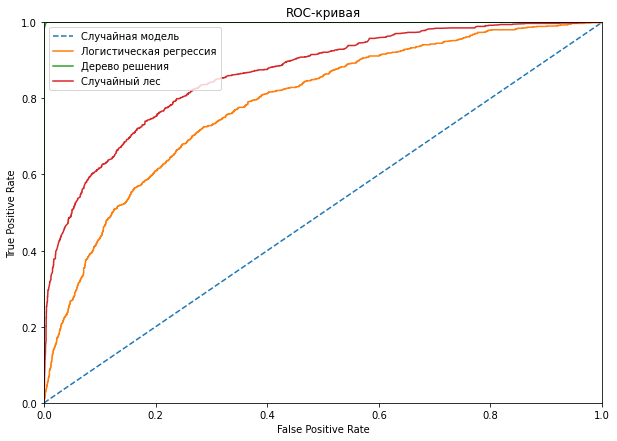

In [34]:
plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_log,tpr_log)
plt.plot(fpr_tree,tpr_tree)
plt.plot(fpr_forest,tpr_forest)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Логистическая регрессия','Дерево решения','Случайный лес'),
           loc= 'upper left') 
plt.show()

Вывод:
Лучшее значение метрики auc roc=0.855 у модели случайный лес.

## Тестирование модели

Случайный лес

In [35]:
model_forest=RandomForestClassifier(class_weight='balanced',max_depth=11,n_estimators=40,random_state=1234).fit(features_balance_up,target_balance_up)
prediction=model_forest.predict(features_test)
print('F1:',f1_score( target_test,prediction))

F1: 0.6501128668171557


Вывод:
Мера F1 поменялась. Стала хуже F1=0.387

## Общий вывод:

In [36]:
rezult1={'Дерево Решения':np.array([0.568,0.617]),'Случайный лес':np.array([0.574,0.740]),'Логистическая регрессия':np.array([0.294,0.735])}
rezult_df=pd.DataFrame(rezult1,index=['R2 без учета дисбаланса','R2 с учетом дисбаланса'])
rezult_df

,Дерево Решения,Случайный лес,Логистическая регрессия
R2 без учета дисбаланса,0.568,0.574,0.294
R2 с учетом дисбаланса,0.617,0.740,0.735


Рассматривая данные с учетом дисбаланса и без учета дисбаланса тремя моделями можно сделать вывод, что самая лучшая модель оказалась Случайный лес. Хуже всего себя показала модель Логическая регрессия.